In [1]:
# 1. Import thư viện cần thiết 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:

# 2. Đọc file dữ liệu  
df = pd.read_csv('GVR.csv') 

#Định dạng cấu trúc thời gian
df['Ngày']=pd.to_datetime(df.Ngày, format ="%d/%m/%Y")
# Sort the dataframe by date in ascending order
df = df.sort_values('Ngày')


df1=df.reset_index()['Lần cuối']


In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
X_train.shape[0]

788

In [9]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 8s 241ms/step - loss: 0.0365 - val_loss: 0.0103
Epoch 2/100
13/13 [==============================] - 3s 196ms/step - loss: 0.0074 - val_loss: 0.0222
Epoch 3/100
13/13 [==============================] - 2s 152ms/step - loss: 0.0034 - val_loss: 0.0136
Epoch 4/100
13/13 [==============================] - 2s 151ms/step - loss: 0.0027 - val_loss: 0.0093
Epoch 5/100
13/13 [==============================] - 2s 152ms/step - loss: 0.0025 - val_loss: 0.0083
Epoch 6/100
13/13 [==============================] - 2s 150ms/step - loss: 0.0024 - val_loss: 0.0082
Epoch 7/100
13/13 [==============================] - 2s 170ms/step - loss: 0.0025 - val_loss: 0.0088
Epoch 8/100
13/13 [==============================] - 2s 178ms/step - loss: 0.0024 - val_loss: 0.0089
Epoch 9/100
13/13 [==============================] - 2s 151ms/step - loss: 0.0023 - val_loss: 0.0099
Epoch 10/100
13/13 [==============================] - 2s 149ms/step - loss: 0.0023 - val_lo

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 46ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 15316.964141517605
Testing RMSE: 25296.626623956985


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape


(1, 67)

In [15]:

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=67
i=0
while(i<30):
    
    if(len(temp_input)>67):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.25293207]
68
1 day input [0.29390786 0.28367633 0.28952292 0.25590505 0.24713517 0.25152011
 0.2573667  0.23398036 0.23251871 0.23836529 0.22959542 0.21059401
 0.21497895 0.22521048 0.23251871 0.23105706 0.25298176 0.25005847
 0.22667212 0.23398036 0.21936389 0.20913237 0.20913237 0.22228718
 0.21790225 0.21351731 0.2164406  0.22228718 0.22521048 0.24421188
 0.23982694 0.23836529 0.21936389 0.24567353 0.235442   0.23690365
 0.22082554 0.22374883 0.22521048 0.22521048 0.23398036 0.23690365
 0.23398036 0.23251871 0.23105706 0.25444341 0.26759822 0.26759822
 0.27490645 0.2573667  0.26613658 0.26613658 0.2763681  0.27929139
 0.26759822 0.24859682 0.25152011 0.25444341 0.24128859 0.24421188
 0.24275023 0.24859682 0.24275023 0.25005847 0.25298176 0.25590505
 0.25293207]
1 day output [[0.25432357]]
2 day input [0.28367633 0.28952292 0.25590505 0.24713517 0.25152011 0.2573667
 0.23398036 0.23251871 0.23836529 0.22959542 0.21059401 0.21497895
 0.22521048 0.23251871 0.23105706 0.25298176 0.25

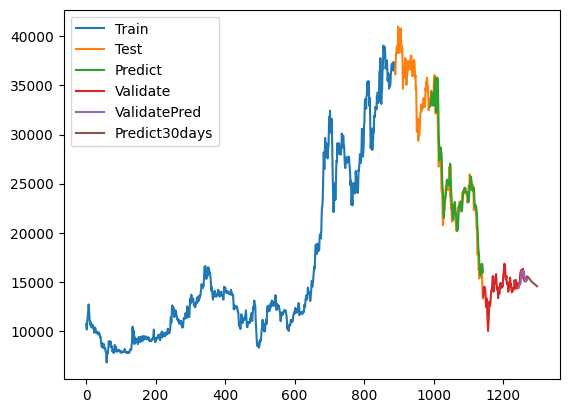

In [16]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()